In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier, to_graphviz
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [43]:
data_path = '/Users/andreslopez/Desktop/ECE3039/Project/survey _lung_cancer.csv'
df = pd.read_csv(data_path)

xvalue = df.drop(['LUNG_CANCER','AGE','GENDER'], axis=1).applymap(lambda x: 'NO' if x == 1 else 'YES')
xvar = df[['AGE']]
xvalue = pd.concat([df['GENDER'],xvalue], axis=1)
x_label = pd.concat([df['AGE'],xvalue], axis=1)
x_label = x_label.columns
xvalue = pd.get_dummies(xvalue)
X = pd.concat([xvar,xvalue], axis=1)
X = X.astype(int)
y = df['LUNG_CANCER'].apply(lambda x: 1 if x == 'YES' else 0)

X.head()

/var/folders/wh/5rf3n2rs4875gpzdn9xgsbnw0000gn/T/ipykernel_57211/889288378.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  xvalue = df.drop(['LUNG_CANCER','AGE','GENDER'], axis=1).applymap(lambda x: 'NO' if x == 1 else 'YES')


,AGE,GENDER_F,GENDER_M,SMOKING_NO,SMOKING_YES,YELLOW_FINGERS_NO,YELLOW_FINGERS_YES,ANXIETY_NO,ANXIETY_YES,PEER_PRESSURE_NO,...,ALCOHOL CONSUMING_NO,ALCOHOL CONSUMING_YES,COUGHING_NO,COUGHING_YES,SHORTNESS OF BREATH_NO,SHORTNESS OF BREATH_YES,SWALLOWING DIFFICULTY_NO,SWALLOWING DIFFICULTY_YES,CHEST PAIN_NO,CHEST PAIN_YES
0,69,0,1,1,0,0,1,0,1,1,...,0,1,0,1,0,1,0,1,0,1
1,74,0,1,0,1,1,0,1,0,1,...,1,0,1,0,0,1,0,1,0,1
2,59,1,0,1,0,1,0,1,0,0,...,1,0,0,1,0,1,1,0,0,1
3,63,0,1,0,1,0,1,0,1,1,...,0,1,1,0,1,0,0,1,0,1
4,63,1,0,1,0,0,1,1,0,1,...,1,0,0,1,0,1,1,0,1,0


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='error', random_state = 42)

param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 10],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [5, 10, 100, 200, 300],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=84)

grid_search = GridSearchCV(estimator= xgb_model,param_grid=param_grid, cv = 5, scoring = 'accuracy' )

grid_search.fit(X_train, y_train)

optimized_model = grid_search.best_estimator_


In [55]:
# Get results
results = pd.DataFrame(grid_search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005642,0.001737,0.001971,0.000262,0.001,2,5,"{'learning_rate': 0.001, 'max_depth': 2, 'n_es...",0.84,0.84,0.857143,0.857143,0.857143,0.850286,0.008398,40
1,0.003782,0.000951,0.001357,0.000051,0.001,2,10,"{'learning_rate': 0.001, 'max_depth': 2, 'n_es...",0.84,0.84,0.857143,0.857143,0.857143,0.850286,0.008398,40
2,0.015073,0.002224,0.001504,0.000065,0.001,2,100,"{'learning_rate': 0.001, 'max_depth': 2, 'n_es...",0.84,0.84,0.857143,0.857143,0.857143,0.850286,0.008398,40
3,0.028216,0.003653,0.001516,0.000076,0.001,2,200,"{'learning_rate': 0.001, 'max_depth': 2, 'n_es...",0.84,0.84,0.857143,0.857143,0.857143,0.850286,0.008398,40
4,0.063432,0.024067,0.001864,0.000290,0.001,2,300,"{'learning_rate': 0.001, 'max_depth': 2, 'n_es...",0.84,0.84,0.857143,0.857143,0.857143,0.850286,0.008398,40


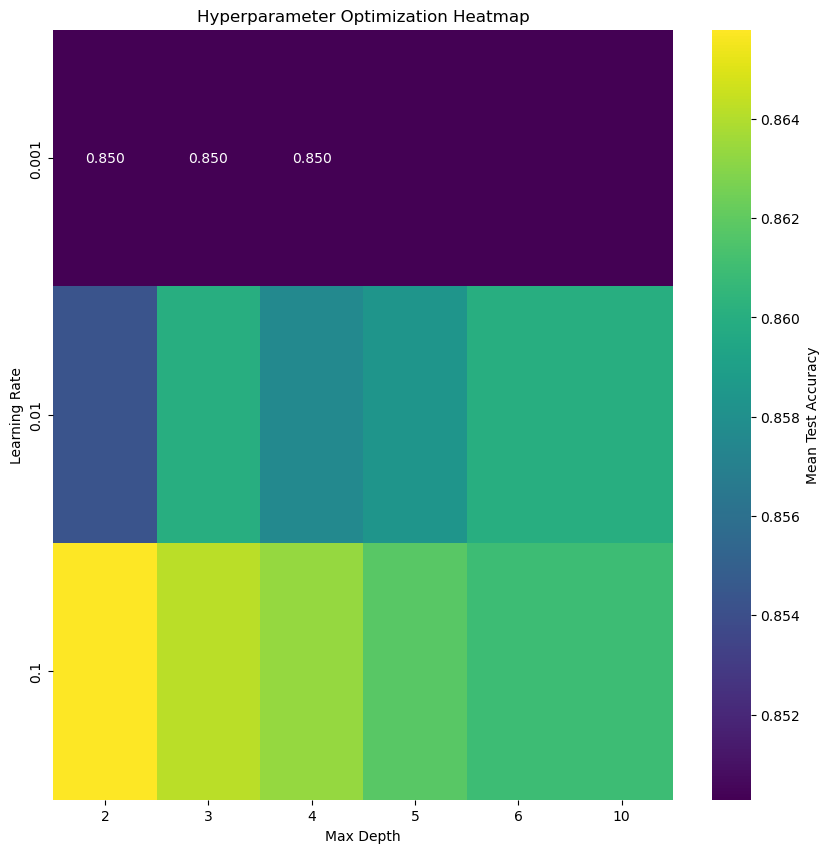

In [56]:
plt.figure(figsize=(10, 10))
heatmap_data = results.pivot_table(index='param_learning_rate', columns='param_max_depth', values='mean_test_score', aggfunc='mean')
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".3f", cbar_kws={'label': 'Mean Test Accuracy'})
plt.title('Hyperparameter Optimization Heatmap')
plt.xlabel('Max Depth')
plt.ylabel('Learning Rate')
plt.show()

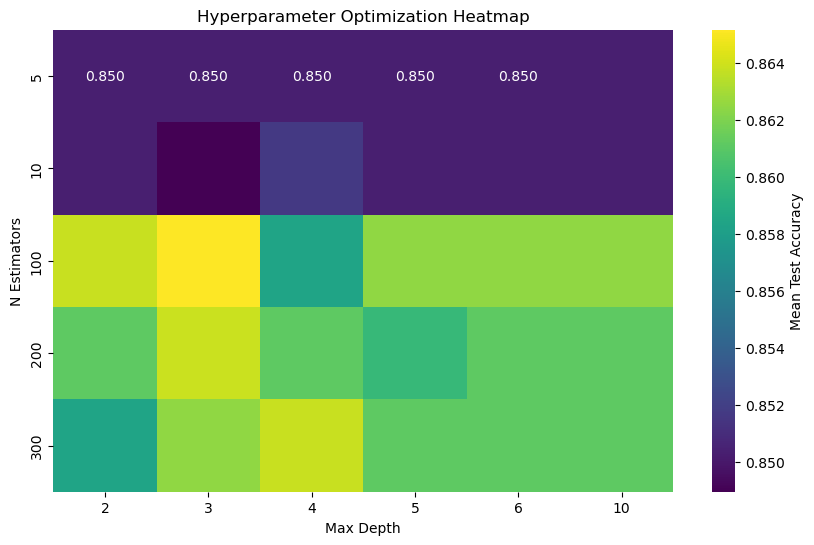

In [57]:
plt.figure(figsize=(10, 6))
heatmap_data = results.pivot_table(index='param_n_estimators', columns='param_max_depth', values='mean_test_score', aggfunc='mean')
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".3f", cbar_kws={'label': 'Mean Test Accuracy'})
plt.title('Hyperparameter Optimization Heatmap')
plt.xlabel('Max Depth')
plt.ylabel('N Estimators')
plt.show()

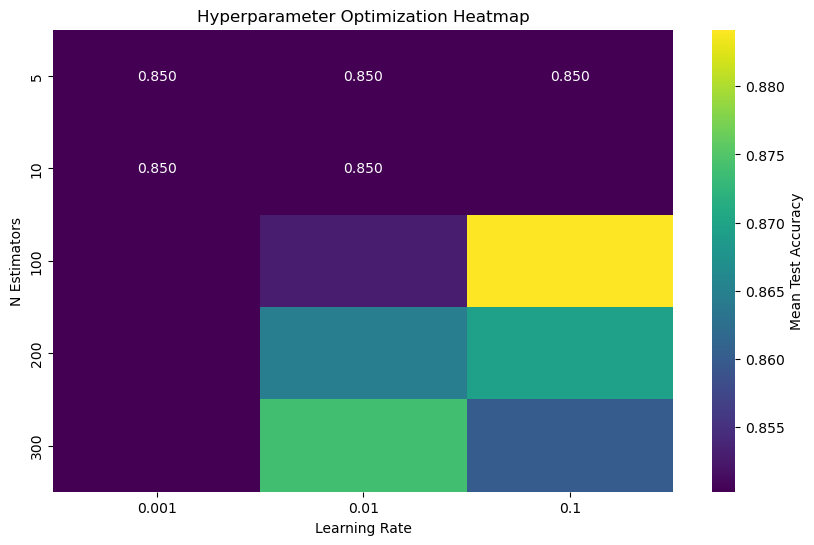

In [58]:
plt.figure(figsize=(10, 6))
heatmap_data = results.pivot_table(index='param_n_estimators', columns='param_learning_rate', values='mean_test_score', aggfunc='mean')
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".3f", cbar_kws={'label': 'Mean Test Accuracy'})
plt.title('Hyperparameter Optimization Heatmap')
plt.xlabel('Learning Rate')
plt.ylabel('N Estimators')
plt.show()

In [60]:
# print the scores on training and test set
print("Best Hyperparameters:", grid_search.best_params_)
print("Cross-validation accuracy:", grid_search.best_score_)
print('Training set score: {:.4f}'.format(optimized_model.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(optimized_model.score(X_test, y_test)))

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
Cross-validation accuracy: 0.8909387755102041
Training set score: 0.9433
Test set score: 0.9677


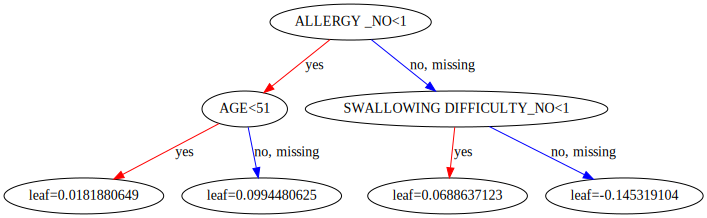

In [61]:
optimized_model.fit(X_train, y_train)

# Plot the final boosting tree of the optimized model
to_graphviz(optimized_model)

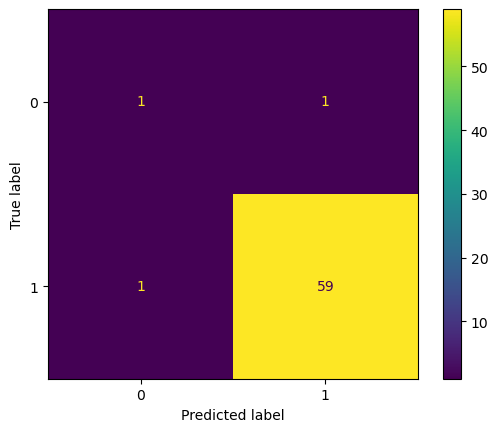


Precision: 0.9833333333333333
Recall: 0.9833333333333333
F1_score: 0.9833333333333333


In [52]:
y_pred = optimized_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm)

disp.plot()
plt.show()

print(f'\nPrecision: {precision}')
print(f'Recall: {recall}')
print(f"F1_score: {f1}")

In [53]:
#Export Model
import joblib

joblib.dump(optimized_model, 'xgboosting_model.pkl')

['xgboosting_model.pkl']